In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
# Evaluate the ML model

import tensorflow as tf
from tensorflow import keras
import os
import glob
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import plot_loss, encdec_files_to_tensors
from utils import get_best_model_timestamp
from utils import load_model_data_new, unnormalize_params, assess_decoder
from utils import sample_files
from models import Encoder, mse_loss_encoder, mse_loss_decoder
from models import encoderDecoderModel

data_dir = '/eos/user/k/kiliakis/tomo_data/datasets_decoder_02-12-22'
dataset_percent = 0.01
normalization = 'minmax'
num_Turns_Case = 1
var_names = ['phEr', 'enEr', 'bl',
             'inten', 'Vrf', 'mu',
             'VrfSPS']



In [3]:
# Initialize parameters
import time

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
TESTING_PATH = os.path.join(ML_dir, 'TESTING')
assert os.path.exists(TESTING_PATH)


# First the training data
file_names = sample_files(TESTING_PATH, dataset_percent, keep_every=num_Turns_Case)

start_t = time.time()
# read input, divide in features/ label, create tensors
wf_test, turn_test, latent_test, ps_test = encdec_files_to_tensors(
    file_names, normalization=normalization)
total_time = time.time() - start_t
print(f'Elapsed time: {total_time:.3f}, Per file: {total_time/len(file_names):.3f}')


2022-12-13 11:12:26.511220: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-12-13 11:12:26.511236: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-13 11:12:26.511249: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist
2022-12-13 11:12:26.511443: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Elapsed time: 48.665, Per file: 0.077


In [13]:
# Models to load
# enc_timestamp = get_best_model_timestamp('./trials', model='enc')
# enc_timestamp = '2022_10_07_15-18-55'
enc_timestamp = 'hybrid'

print('Encoder: ', enc_timestamp)

# Initialize directories
enc_trial_dir = os.path.join('./trials/', enc_timestamp)
enc_weights_dir = os.path.join(enc_trial_dir, 'weights')
# enc_plots_dir = os.path.join(enc_trial_dir, 'plots')
# assert os.path.exists(enc_weights_dir)
# os.makedirs(enc_plots_dir, exist_ok=True)

dec_timestamp = '2022_12_13_08-57-08'
print('Decoder: ', dec_timestamp)

# Initialize directories
dec_trial_dir = os.path.join('./trials/', dec_timestamp)
dec_weights_dir = os.path.join(dec_trial_dir, 'weights')
# dec_plots_dir = os.path.join(dec_trial_dir, 'plots')
# assert os.path.exists(dec_weights_dir)
# os.makedirs(dec_plots_dir, exist_ok=True)

encDec = encoderDecoderModel(enc_weights_dir, dec_weights_dir)

# load the model
# encoder = keras.models.load_model(os.path.join(enc_weights_dir, 'encoder.h5'))

# Model to load
# dec_timestamp = get_best_model_timestamp('./trials', model='dec')


# load the model
# decoder = keras.models.load_model(os.path.join(dec_weights_dir, 'decoder.h5'))


# Initialize the end to end model
# encDec = encoderDecoderModel(encoder, decoder)


Encoder:  hybrid
Decoder:  2022_12_13_08-57-08


In [14]:

# Evaluate the model on the test and validation data
latent_pred, ps_pred = encDec.predictPS(wf_test, turn_test)

# Evaluate the latent space agreemet 
latent_mse = mean_squared_error(latent_test, latent_pred, multioutput='raw_values') 
print('Variable\tMSE')
for name, mse in zip(var_names, latent_mse):
    print(f'{name}:\t{mse:.3e}')

# Evaluate the PS agreement
ps_enc_dec_mse = np.mean((ps_test - ps_pred)**2, axis=0).reshape((128, 128))
print('\nPS ENC-DEC MSE: ', np.mean(ps_enc_dec_mse))

# Evaluate the PS agreement with perfect encoder
ps_dec_pred = encDec.decode(latent_test, turn_test)
ps_dec_mse = np.mean((ps_test - ps_dec_pred)**2, axis=0).reshape((128, 128))
print('\nPS DEC MSE: ', np.mean(ps_dec_mse))



[2.4593792e-05 2.0287109e-05 1.5708857e-04 8.3520696e-02 6.9739071e-05
 9.0657274e-04 1.1887944e-03]
Variable	MSE
phEr:	2.459e-05
enEr:	2.029e-05
bl:	1.571e-04
inten:	8.352e-02
Vrf:	6.974e-05
mu:	9.066e-04
VrfSPS:	1.189e-03

PS ENC-DEC MSE:  0.07245055

PS DEC MSE:  0.07355544


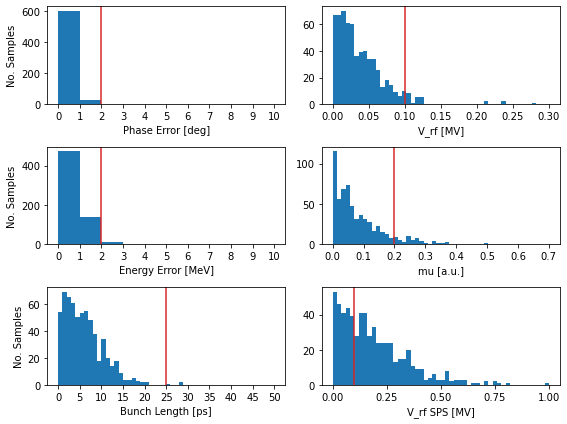

In [17]:
# Encoder, graphical evaluation

# unormalized latent space
latent_unnorm = unnormalize_params(
    latent_test[:, 0], latent_test[:, 1], latent_test[:, 2],
    latent_test[:, 3], latent_test[:, 4], latent_test[:, 5],
    latent_test[:, 6], normalization=normalization)
latent_unnorm = np.array(latent_unnorm).T

# unormalized predicted latent space
latent_pred_unnorm = unnormalize_params(
    latent_pred[:, 0], latent_pred[:, 1], latent_pred[:, 2],
    latent_pred[:, 3], latent_pred[:, 4], latent_pred[:, 5],
    latent_pred[:, 6], normalization=normalization)
latent_pred_unnorm = np.array(latent_pred_unnorm).T

# absolute difference
diffs = np.abs(latent_unnorm - latent_pred_unnorm)


fig, axes = plt.subplots(ncols=2, nrows=3, sharex=False,
                         sharey=False, figsize=(8, 6))

plt.sca(axes[0][0])
plt.hist(diffs[:, 0], bins=10, range=(0, 10))
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Phase Error [deg]')
plt.ylabel('No. Samples')
plt.axvline(x=2, color='tab:red')

plt.sca(axes[1][0])
plt.hist(diffs[:, 1], bins=10, range=(0, 10))
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Energy Error [MeV]')
plt.ylabel('No. Samples')
plt.axvline(x=2, color='tab:red')

plt.sca(axes[2][0])
plt.hist(diffs[:, 2]*1e12, bins=50, range=(0, 50))
plt.xticks(np.arange(0, 50.5, 5))
plt.xlabel('Bunch Length [ps]')
plt.ylabel('No. Samples')
plt.axvline(x=25, color='tab:red')

plt.sca(axes[0][1])
plt.hist(diffs[:, 4], bins=50, range=(0, 0.3))
plt.xlabel('V_rf [MV]')
plt.axvline(x=0.1, color='tab:red')

plt.sca(axes[1][1])
plt.hist(diffs[:, 5], bins=50, range=(0, 0.7))
plt.xticks(np.arange(0, 0.71, 0.1))
plt.xlabel('mu [a.u.]')
plt.axvline(x=0.2, color='tab:red')

plt.sca(axes[2][1])
plt.hist(diffs[:, 6], bins=50, range=(0, 1))
plt.xticks(np.arange(0, 1.1, 0.25))
plt.xlabel('V_rf SPS [MV]')
plt.axvline(x=0.1, color='tab:red')

plt.tight_layout()


Text(0.5, 1.0, 'Pred PS')

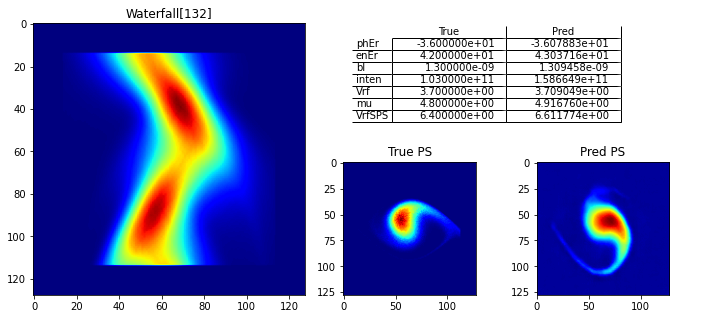

In [63]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
# here I need a plot with:
# waterfall (left), middle table of latent space, right PS
# fig = plt.figure(constrained_layout=True)
# gs = GridSpec(2, 3)
# ax0 = fig.add_subplot(gs[:, 0])
# ax1 = fig.add_subplot(gs[:, 0])
fig, axes = plt.subplot_mosaic(mosaic=[['WF', 'TAB', 'TAB'],
                                       ['WF', 'PS_TRUE', 'PS_PRED']],
                               gridspec_kw={'width_ratios': [3, 2, 2],
                               'hspace':0.05, 'wspace': 0.02},
                               figsize=(12, 5))
# print(len(axes))

# fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 5),
#                          gridspec_kw={'width_ratios': [4, 2, 4]},
#                          sharex=False, sharey=False)
# # get random id
sample_id = np.random.randint(low=0, high=len(file_names))
wf_s = np.array(wf_test[sample_id]).reshape(128, 128).T
latent_true_s = latent_unnorm[sample_id]
latent_pred_s = latent_pred_unnorm[sample_id]
turn_s = turn_test[sample_id]
ps_true_s = ps_test[sample_id]
ps_pred_s = ps_pred[sample_id]

# # start with left plot, the waterfall
plt.sca(axes['WF'])
plt.imshow(wf_s, cmap='jet')
plt.title(f'Waterfall[{sample_id}]')

# center plot
plt.sca(axes['TAB'])
celltext = []
for true_val, pred_val in zip(latent_true_s, latent_pred_s):
    celltext.append([f'{true_val:2e}', f'{pred_val:2e}'])

plt.table(celltext, colLabels=['True', 'Pred'],
            rowLabels=var_names,
          loc='upper center',
          colWidths=[0.3, 0.3],
          edges='BR')
axes['TAB'].axis('off')

# top right plot
plt.sca(axes['PS_TRUE'])
plt.imshow(ps_true_s, cmap='jet')
plt.title(f'True PS')

# bottom right plot
plt.sca(axes['PS_PRED'])
plt.imshow(ps_pred_s, cmap='jet')
plt.title(f'Pred PS')

# plt.tight_layout()